In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize
import re
from datasets import load_dataset
import torch
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
import xgboost as xgb

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
df = pd.read_csv('/content/beta_user_dataset_augmented.csv')
df.head()

,user_id,session_count,avg_session_duration,feature_1_usage,feature_2_usage,total_actions,last_active_days_ago,crash_count,feedback_submitted,device_type,gender,education,age,mode,churned
0,U0001,12,7.43,2,7,189,18,0,0,Android,female,JEE,28,0,1
1,U0002,6,7.44,3,3,171,4,0,0,Android,male,college,30,1,0
2,U0003,11,6.88,7,3,489,22,1,0,iOS,female,college,18,1,1
3,U0004,14,6.04,5,4,294,26,0,0,Android,male,college,23,1,1
4,U0005,7,7.35,5,5,70,21,0,1,Android,female,NEET,23,1,1


In [ ]:
df.isnull().count()

,0
user_id,5000
session_count,5000
avg_session_duration,5000
feature_1_usage,5000
feature_2_usage,5000
total_actions,5000
last_active_days_ago,5000
crash_count,5000
feedback_submitted,5000
device_type,5000


In [ ]:
!pip install xgboost scikit-learn pandas matplotlib seaborn --quiet

In [ ]:
df.drop(columns = ["feedback_submitted", "device_type"])

,user_id,session_count,avg_session_duration,feature_1_usage,feature_2_usage,total_actions,last_active_days_ago,crash_count,gender,education,age,mode,churned
0,U0001,12,7.43,2,7,189,18,0,female,JEE,28,0,1
1,U0002,6,7.44,3,3,171,4,0,male,college,30,1,0
2,U0003,11,6.88,7,3,489,22,1,female,college,18,1,1
3,U0004,14,6.04,5,4,294,26,0,male,college,23,1,1
4,U0005,7,7.35,5,5,70,21,0,female,NEET,23,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,U4996,13,7.97,4,8,304,3,0,male,JEE,24,0,0
4996,U4997,12,4.70,5,5,187,6,2,male,JEE,19,0,0
4997,U4998,8,5.61,5,12,108,4,2,male,school,26,1,0
4998,U4999,12,7.10,6,8,93,8,1,female,NEET,21,1,0


In [ ]:
from sklearn.preprocessing import LabelEncoder

le_gender = LabelEncoder()
df['gender_encoded'] = le_gender.fit_transform(df['gender'])

le_education = LabelEncoder()
df['education_encoded'] = le_education.fit_transform(df['education'])

df.head()

,user_id,session_count,avg_session_duration,feature_1_usage,feature_2_usage,total_actions,last_active_days_ago,crash_count,feedback_submitted,device_type,gender,education,age,mode,churned,gender_encoded,education_encoded
0,U0001,12,7.43,2,7,189,18,0,0,Android,female,JEE,28,0,1,0,0
1,U0002,6,7.44,3,3,171,4,0,0,Android,male,college,30,1,0,1,2
2,U0003,11,6.88,7,3,489,22,1,0,iOS,female,college,18,1,1,0,2
3,U0004,14,6.04,5,4,294,26,0,0,Android,male,college,23,1,1,1,2
4,U0005,7,7.35,5,5,70,21,0,1,Android,female,NEET,23,1,1,0,1


In [ ]:
df = df.drop(columns=["feedback_submitted", "device_type", "gender", "education"])

X = df.drop(columns=["churned", "user_id"])
y = df['churned']

In [ ]:
print("Shape:", df.shape)
print("\nData Types:\n", df.dtypes)
print("\nMissing values:\n", df.isnull().sum())

Shape: (5000, 13)

Data Types:
 user_id                  object
session_count             int64
avg_session_duration    float64
feature_1_usage           int64
feature_2_usage           int64
total_actions             int64
last_active_days_ago      int64
crash_count               int64
age                       int64
mode                      int64
churned                   int64
gender_encoded            int64
education_encoded         int64
dtype: object

Missing values:
 user_id                 0
session_count           0
avg_session_duration    0
feature_1_usage         0
feature_2_usage         0
total_actions           0
last_active_days_ago    0
crash_count             0
age                     0
mode                    0
churned                 0
gender_encoded          0
education_encoded       0
dtype: int64


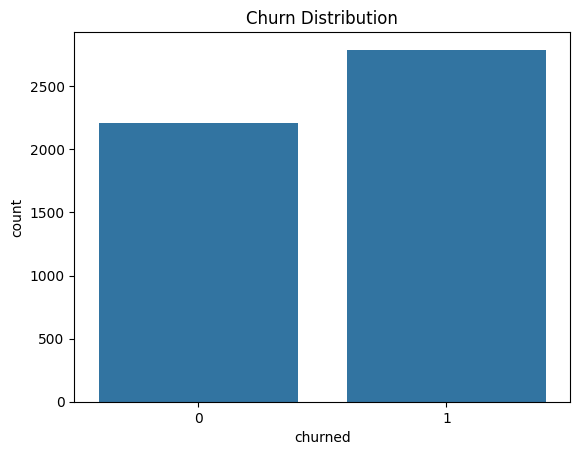

In [ ]:
sns.countplot(x='churned', data=df)
plt.title("Churn Distribution")
plt.show()

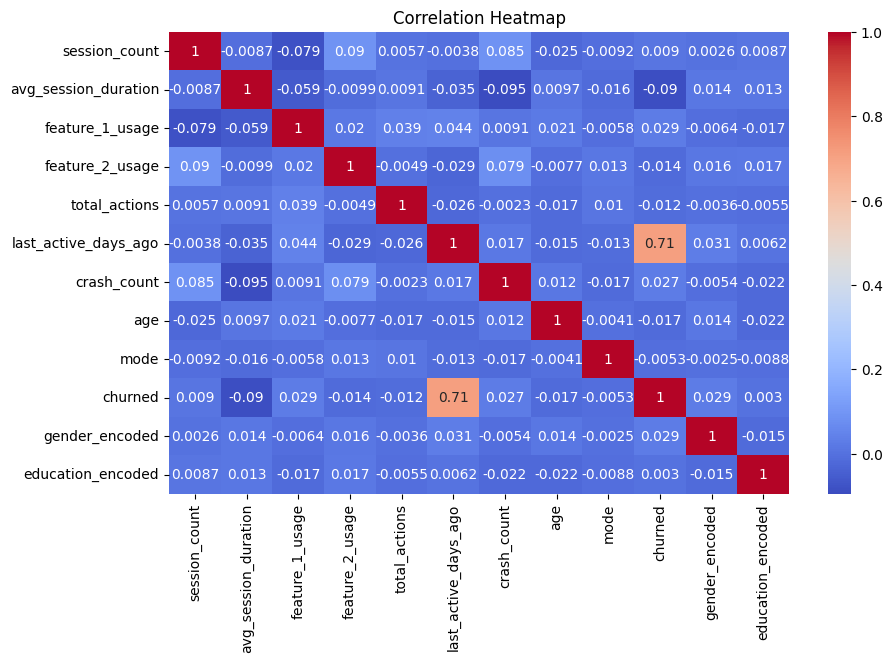

In [ ]:
plt.figure(figsize=(10,6))
sns.heatmap(df.select_dtypes(include=np.number).corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
from sklearn.model_selection import GridSearchCV

xgb_clf = xgb.XGBClassifier(
    scale_pos_weight=len(y_train[y_train == 0]) / len(y_train[y_train == 1]),
    objective='binary:logistic',
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1],
    'colsample_bytree': [0.8, 1]
}

grid_search = GridSearchCV(estimator=xgb_clf,
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=5,
                           verbose=1,
                           n_jobs=-1)

grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
print("Best parameters:", grid_search.best_params_)


Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best parameters: {'colsample_bytree': 1, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 200, 'subsample': 1}


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:45:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [ ]:
model = xgb.XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    use_label_encoder=False,
    random_state=42
)

In [ ]:
model.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:54:05] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [ ]:
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.991

Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99       448
           1       1.00      0.98      0.99       552

    accuracy                           0.99      1000
   macro avg       0.99      0.99      0.99      1000
weighted avg       0.99      0.99      0.99      1000



<ipython-input-91-1890345262>:31: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.


<ipython-input-91-1890345262>:32: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.


<ipython-input-91-1890345262>:31: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.


<ipython-input-91-1890345262>:32: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.


<ipython-input-91-1890345262>:31: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.


<ipython-input-91-1890345262>:32: Future

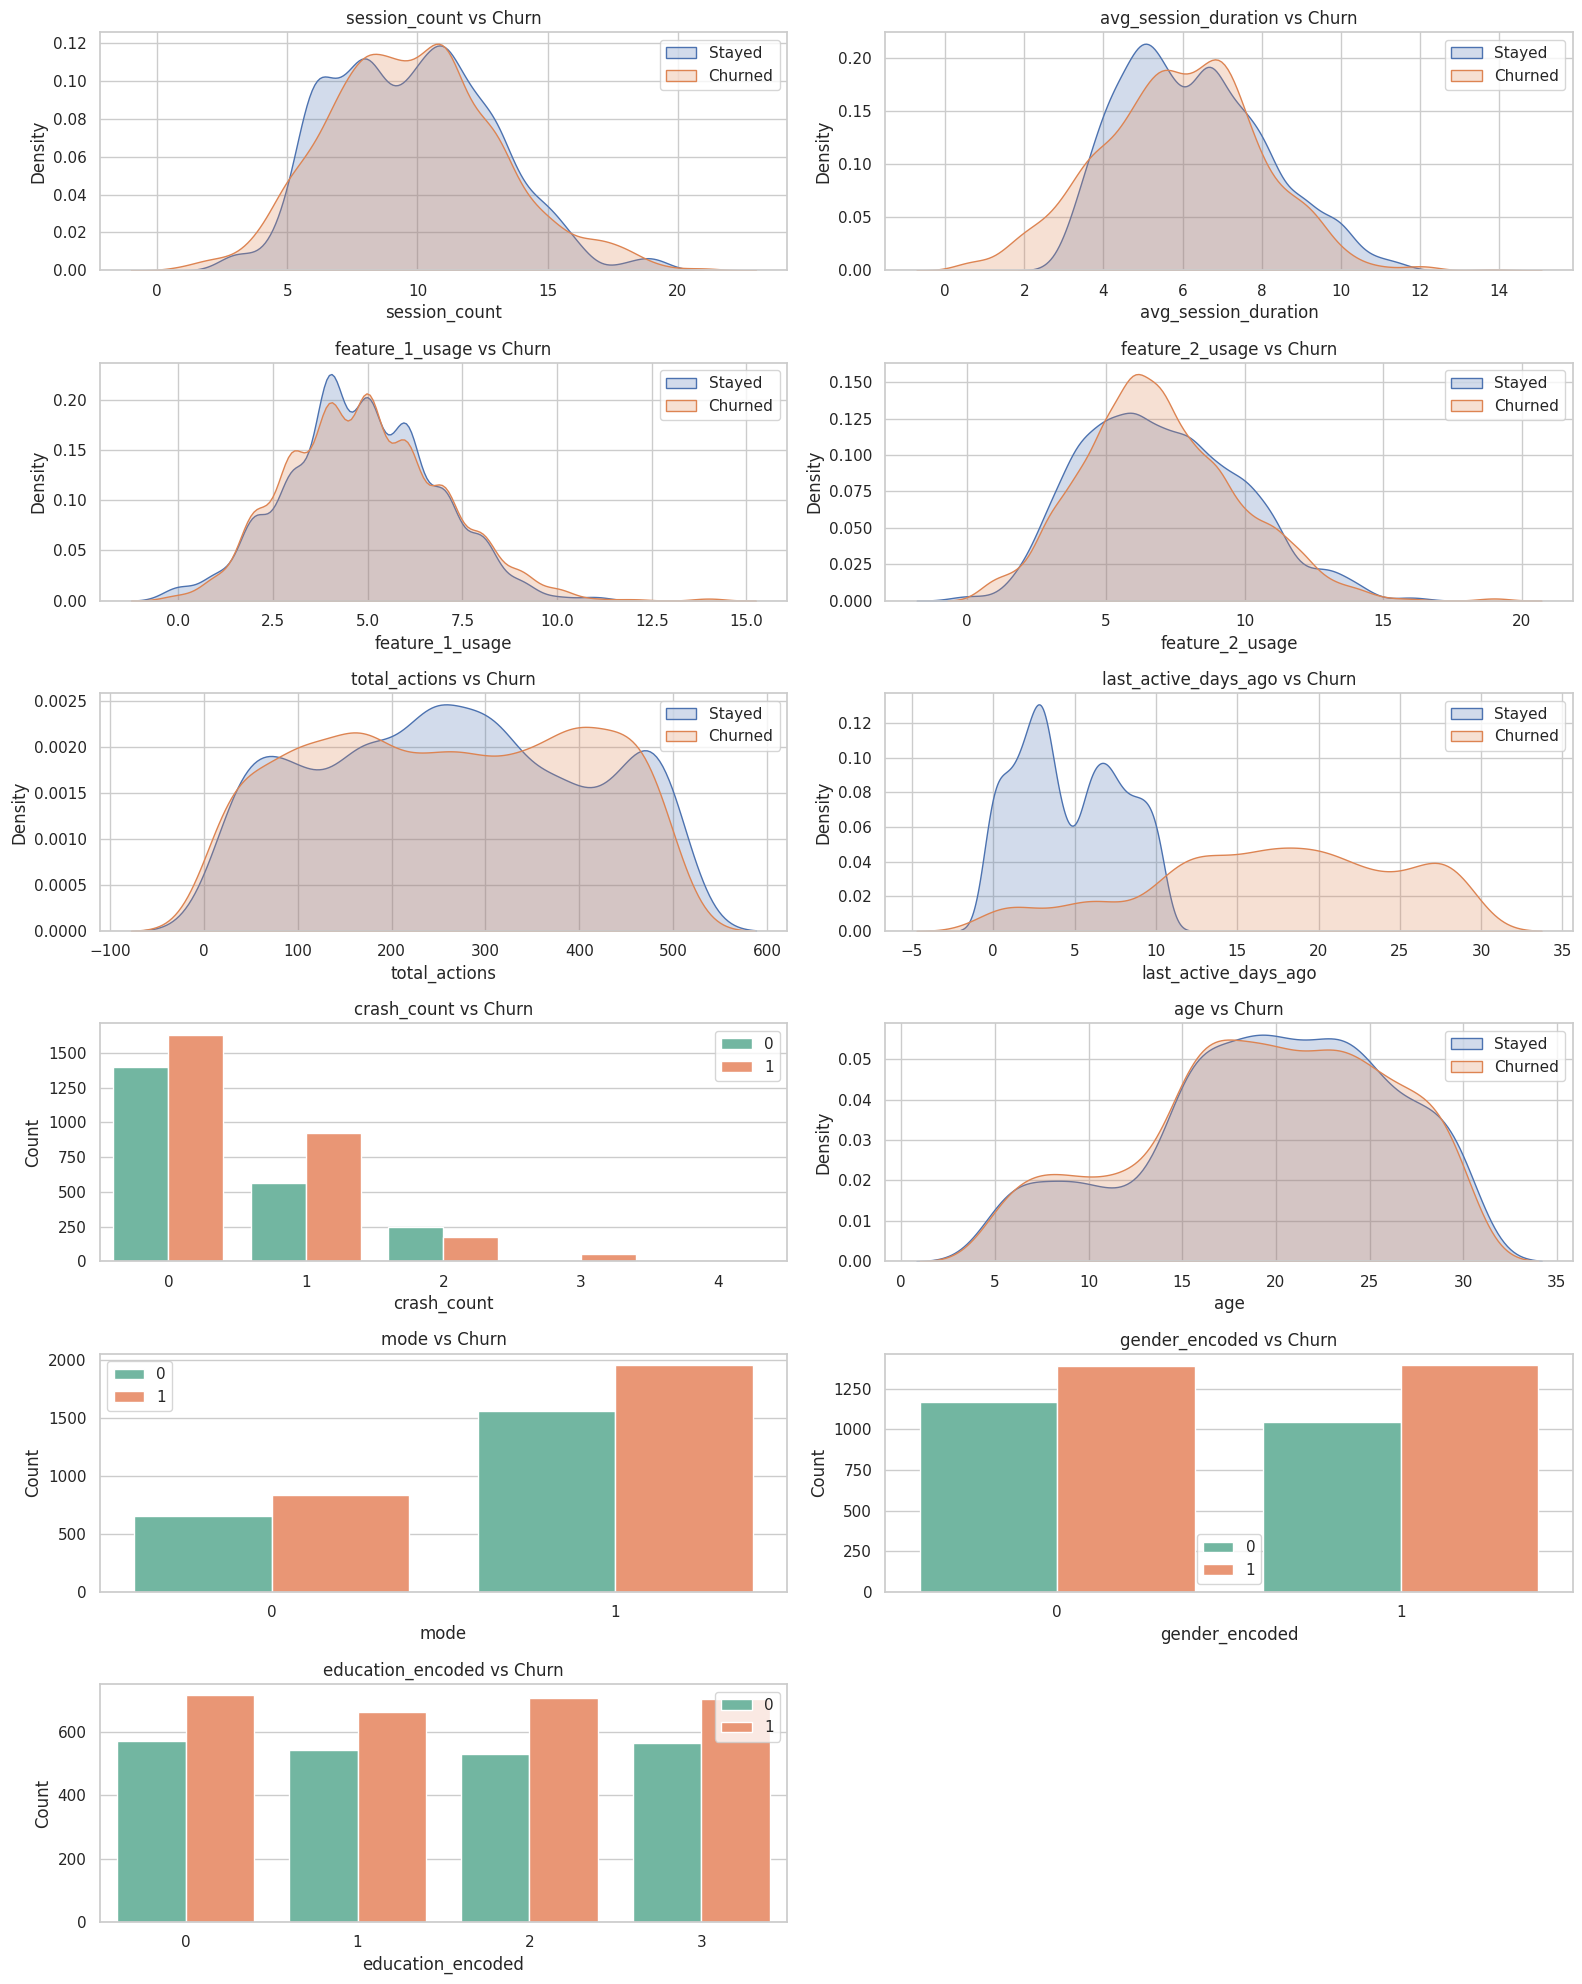

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set(style="whitegrid")
plt.figure(figsize=(16, 20))

# Features to plot
# Removed 'feedback_submitted' and 'device_type' as they were dropped from the DataFrame
features = [
    'session_count', 'avg_session_duration', 'feature_1_usage',
    'feature_2_usage', 'total_actions', 'last_active_days_ago',
    'crash_count',
    'age', 'mode', 'gender_encoded', 'education_encoded'
]

# Plot layout
rows = (len(features) + 1) // 2

# Plot each feature
for i, feature in enumerate(features):
    plt.subplot(rows, 2, i+1)

    # Check the number of unique values to decide between countplot and kdeplot
    # Use .nunique() or len(df[feature].unique())
    if df[feature].nunique() <= 10:
        # Categorical: Use countplot
        sns.countplot(data=df, x=feature, hue='churned', palette='Set2')
    else:
        # Numerical: Use histogram (kdeplot for density)
        sns.kdeplot(data=df[df['churned'] == 0], x=feature, label='Stayed', shade=True)
        sns.kdeplot(data=df[df['churned'] == 1], x=feature, label='Churned', shade=True)

    plt.title(f"{feature} vs Churn")
    plt.xlabel(feature)
    plt.ylabel("Density" if df[feature].nunique() > 10 else "Count")
    plt.legend()

plt.tight_layout()
plt.show()